Import Library

In [ ]:
# Import library
from google.colab import drive
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pickle

Load Dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Jumlah Gambar AI   : 400
Jumlah Gambar Real : 400
Total Gambar       : 800


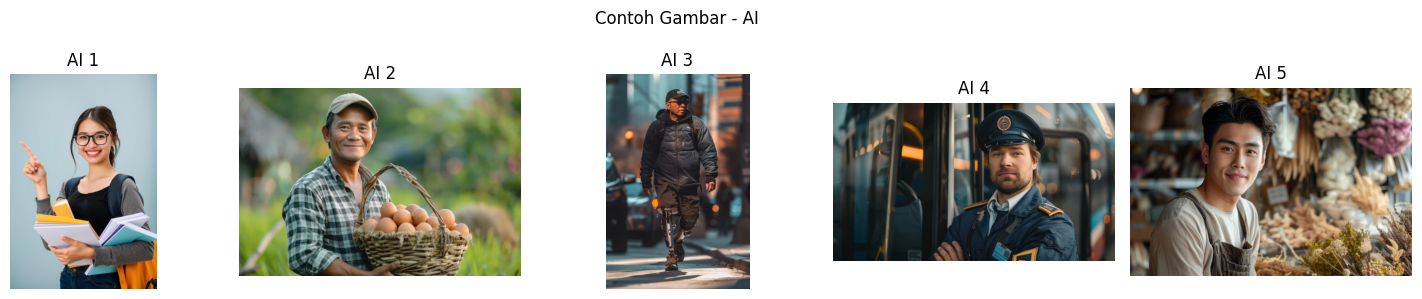

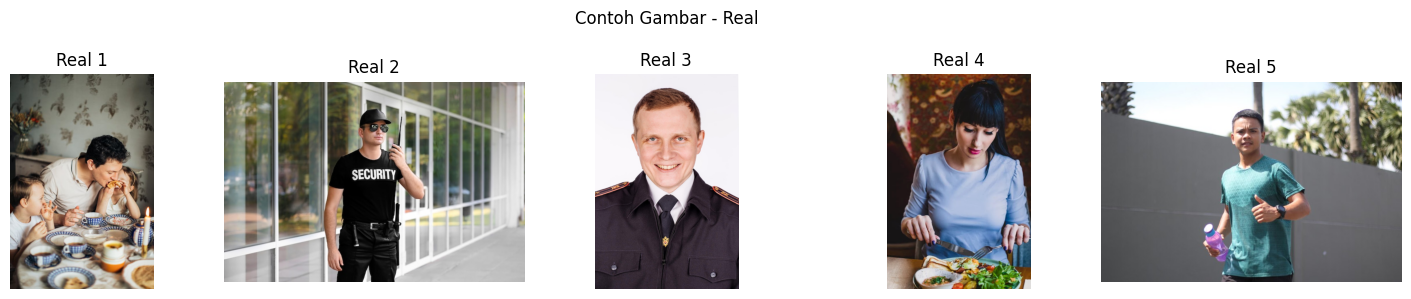

In [ ]:
# 1. Fungsi untuk Mount Google Drive dan Mengatur Path Dataset
def mount_drive_and_load_paths():
    drive.mount('/content/drive')

    # Tentukan base path folder dataset
    base_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI')

    # Kembalikan path ke folder AI dan Real
    return base_path / 'AI Image', base_path / 'Real Image'

# 2. Fungsi untuk Mengambil Semua Path Gambar
def load_image_paths(ai_path, real_path):
    # Ambil semua path gambar AI dan urutkan
    ai_images = sorted(glob(str(ai_path / '*')))

    # Ambil semua path gambar Real dan urutkan
    real_images = sorted(glob(str(real_path / '*')))

    return ai_images, real_images

# 3. Fungsi untuk Menampilkan Informasi Jumlah Dataset
def show_dataset_info(ai_images, real_images):
    print(f"Jumlah Gambar AI   : {len(ai_images)}")
    print(f"Jumlah Gambar Real : {len(real_images)}")
    print(f"Total Gambar       : {len(ai_images) + len(real_images)}")

# 4. Fungsi untuk Menampilkan Contoh Gambar dari Setiap Kelas
def plot_example_images(image_paths, title):
    plt.figure(figsize=(15, 3))

    # Tampilkan 5 contoh gambar pertama dari daftar image_paths
    for i, path in enumerate(image_paths[:5]):
        img = cv2.imread(path)

        # Lewati jika gambar tidak bisa dibaca
        if img is None:
            continue

        # Konversi BGR ke RGB agar warna tidak terbalik
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot gambar
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i + 1}')
        plt.axis('off')

    # Judul utama untuk semua subplot
    plt.suptitle(f'Contoh Gambar - {title}')
    plt.tight_layout()
    plt.show()

# 5. Pemanggilan Semua Fungsi Utama

# Mount Google Drive dan ambil path ke folder AI & Real
ai_path, real_path = mount_drive_and_load_paths()

# Ambil semua path gambar dari kedua kelas
ai_images, real_images = load_image_paths(ai_path, real_path)

# Tampilkan informasi jumlah dataset
show_dataset_info(ai_images, real_images)

# Tampilkan contoh gambar untuk kelas AI
plot_example_images(ai_images, "AI")

# Tampilkan contoh gambar untuk kelas Real
plot_example_images(real_images, "Real")


#Augmentasi

In [ ]:
# 1. Folder Tujuan Hasil Augmentasi
augmented_base_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented')
(augmented_base_path / 'AI').mkdir(parents=True, exist_ok=True)
(augmented_base_path / 'Real').mkdir(parents=True, exist_ok=True)

def apply_augmentation(image_path, save_folder):
    img = cv2.imread(image_path)
    if img is None:
        return

    filename = Path(image_path).stem

    # 1. Gambar Asli (Original)
    cv2.imwrite(str(save_folder / f"{filename}_orig.jpg"), img)

    # 2. Flip Horizontal
    flip_img = cv2.flip(img, 1)
    cv2.imwrite(str(save_folder / f"{filename}_flip.jpg"), flip_img)

    # 3. Rotasi 10 Derajat
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 10, 1.0)
    rot_img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    cv2.imwrite(str(save_folder / f"{filename}_rot.jpg"), rot_img)

    # 4. Zoom
    zoom_factor = 0.85
    h_start, w_start = int(h * (1-zoom_factor)/2), int(w * (1-zoom_factor)/2)
    h_end, w_end = h - h_start, w - w_start
    zoom_img = img[h_start:h_end, w_start:w_end]
    zoom_img = cv2.resize(zoom_img, (w, h))
    cv2.imwrite(str(save_folder / f"{filename}_zoom.jpg"), zoom_img)

# 2. Proses Semua Gambar AI
print("Sedang memproses augmentasi gambar AI...")
for path in ai_images:
    apply_augmentation(path, augmented_base_path / 'AI')

# 3. Proses Semua Gambar Real
print("Sedang memproses augmentasi gambar Real...")
for path in real_images:
    apply_augmentation(path, augmented_base_path / 'Real')

print("Gambar berjumlah 3.200 di folder Dataset_Augmented.")

Sedang memproses augmentasi gambar AI...
Sedang memproses augmentasi gambar Real...
Gambar berjumlah 3.200 di folder Dataset_Augmented.


In [ ]:
augmented_ai_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented/AI')
augmented_real_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented/Real')

ai_images = sorted(glob(str(augmented_ai_path / '*.jpg')))
real_images = sorted(glob(str(augmented_real_path / '*.jpg')))

print(f"Jumlah Gambar AI   : {len(ai_images)}")
print(f"Jumlah Gambar Real : {len(real_images)}")
print(f"Total Gambar       : {len(ai_images) + len(real_images)}")

Jumlah Gambar AI   : 1600
Jumlah Gambar Real : 1600
Total Gambar       : 3200


Pra-pemrosesan Gambar

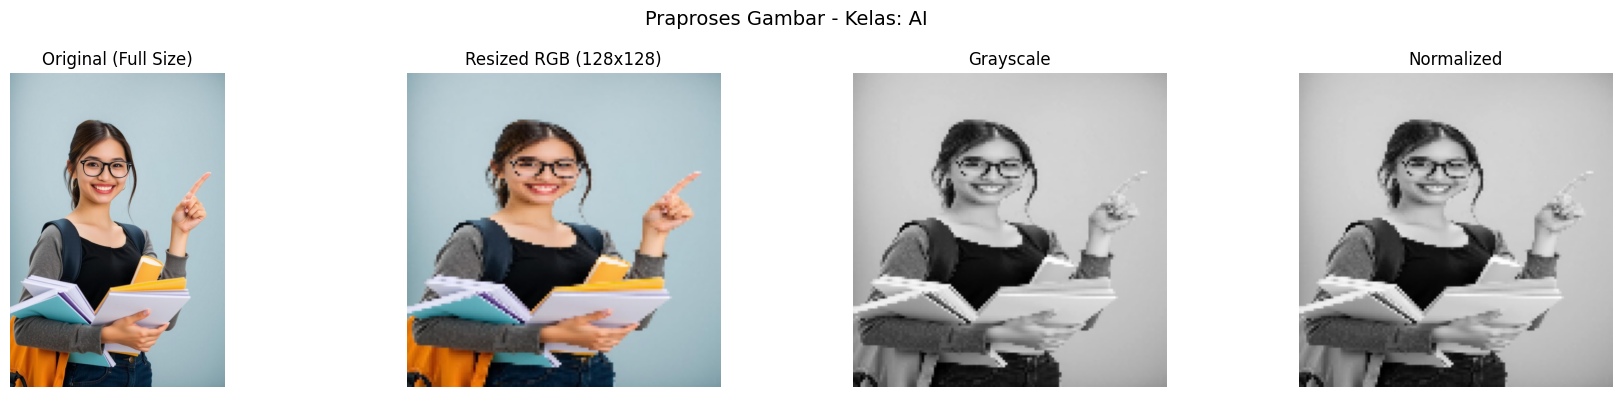

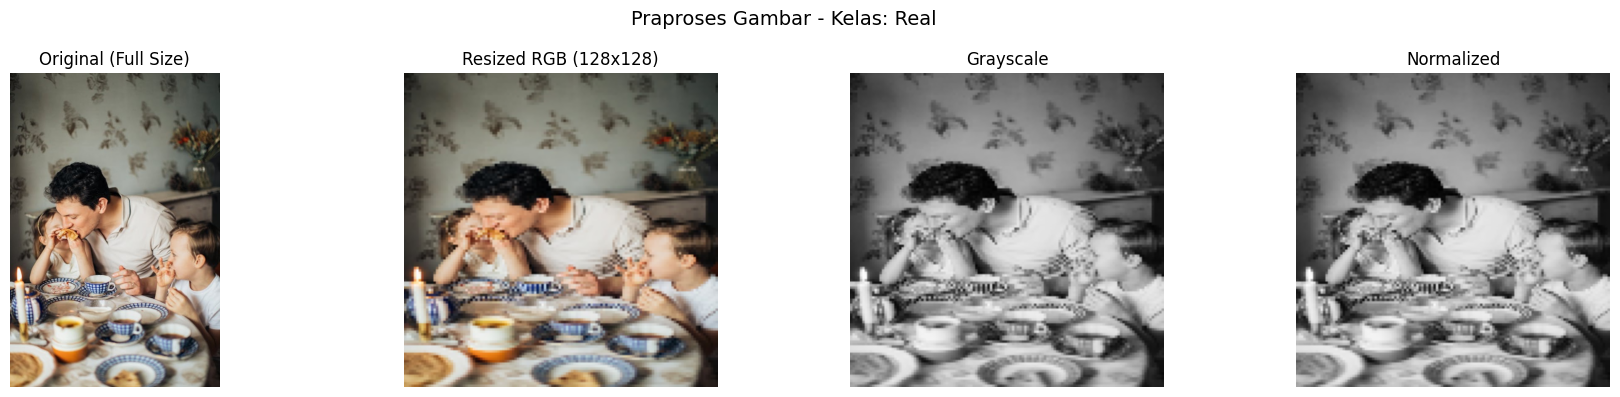

In [ ]:
# 1. folder Dataset Augmented
augmented_ai_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented/AI')
augmented_real_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented/Real')

# Ambil semua path gambar dari folder AI & Real
ai_images = sorted(glob(str(augmented_ai_path / '*.jpg')))
real_images = sorted(glob(str(augmented_real_path / '*.jpg')))

# 2. Fungsi Preprocessing
def preprocess_images(image_paths, label):
    """
    Memproses semua gambar:
    - Resize ke 128x128
    - Konversi ke grayscale
    - Normalisasi grayscale (0-1)
    - Menyimpan RGB resize untuk histogram
    """
    images_gray = []       # Grayscale dan normalisasi untuk LBP/HOG
    images_rgb = []        # RGB resize untuk histogram
    labels = []            # Label tiap gambar
    originals = []         # Original (full size RGB)

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue

        # Simpan original RGB
        original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        originals.append(original_rgb)

        # Resize RGB ke 128x128
        resized_rgb = cv2.resize(original_rgb, (128, 128))
        images_rgb.append(resized_rgb)

        # Grayscale
        gray = cv2.cvtColor(resized_rgb, cv2.COLOR_RGB2GRAY)

        # Normalisasi 0-1
        norm_gray = gray / 255.0
        images_gray.append(norm_gray)

        # Label
        labels.append(label)

    return images_gray, images_rgb, labels, originals

# 3. Proses Semua Gambar
ai_gray, ai_rgb, ai_labels, ai_originals = preprocess_images(ai_images, label=1)
real_gray, real_rgb, real_labels, real_originals = preprocess_images(real_images, label=0)

# Gabungkan kelas AI & Real
X_gray = ai_gray + real_gray
X_rgb = ai_rgb + real_rgb
y = ai_labels + real_labels

# 4. Fungsi Visualisasi Preprocessing
def show_full_preprocessing(original_img, resized_rgb, label_name):
    grayscale = cv2.cvtColor(resized_rgb, cv2.COLOR_RGB2GRAY)
    normalized = grayscale / 255.0

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].imshow(original_img)
    axs[0].set_title("Original (Full Size)")
    axs[1].imshow(resized_rgb)
    axs[1].set_title("Resized RGB (128x128)")
    axs[2].imshow(grayscale, cmap='gray')
    axs[2].set_title("Grayscale")
    axs[3].imshow(normalized, cmap='gray')
    axs[3].set_title("Normalized")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f"Praproses Gambar - Kelas: {label_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

# 5. Contoh Visualisasi Sampel
show_full_preprocessing(ai_originals[0], ai_rgb[0], "AI")
show_full_preprocessing(real_originals[0], real_rgb[0], "Real")


Ekstraksi Fitur

HOG

Ekstraksi HOG selesai!
Bentuk array fitur HOG: (3200, 8100)
Jumlah label: 3200


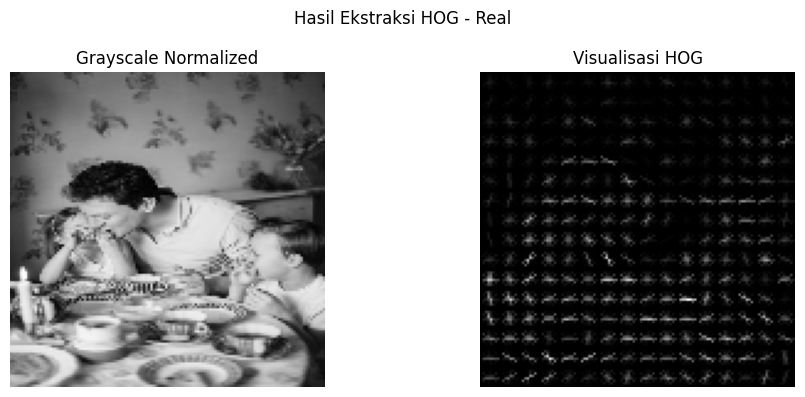

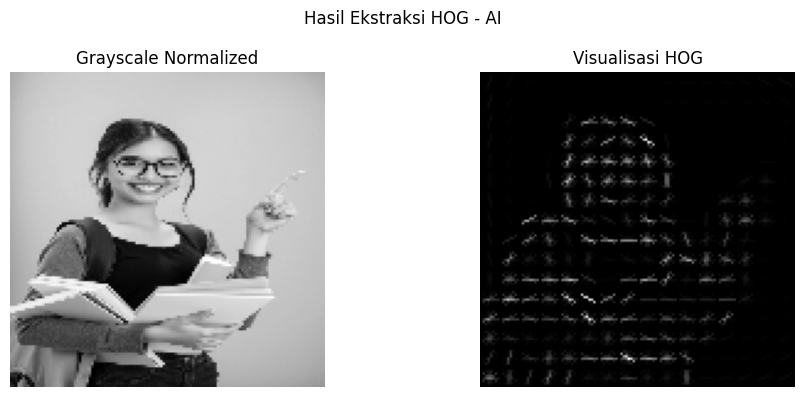


VEKTOR FITUR HOG UNTUK SETIAP KELAS

--- Kelas: REAL ---
Panjang Vektor: 8100
Contoh 20 angka pertama dari vektor:
[0.255572   0.13484805 0.255572   0.25178867 0.25399161 0.06314878
 0.255572   0.18801194 0.255572   0.1283747  0.         0.
 0.         0.         0.10874577 0.20485924 0.255572   0.11926217
 0.255572   0.255572  ]

VEKTOR FITUR HOG UNTUK SETIAP KELAS

--- Kelas: AI ---
Panjang Vektor: 8100
Contoh 20 angka pertama dari vektor:
[0.35187507 0.35187507 0.07199683 0.         0.0728475  0.
 0.         0.         0.         0.32464487 0.35187507 0.25359241
 0.0501206  0.00560365 0.         0.         0.01253015 0.
 0.35187507 0.34150252]


In [ ]:
# HOG: Ekstraksi, Visualisasi, dan Tampilkan Vektor

# 1. Fungsi Ekstraksi HOG

def extract_hog(images):
    """
    Ekstraksi fitur HOG dari list citra grayscale normalisasi
    """
    features = []

    for img in images:
        feat, _ = hog(img,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True)
        features.append(feat)

    return np.array(features)

# 2. Fungsi Visualisasi HOG
def show_hog_example(image_gray, label_name):
    """
    Menampilkan HOG untuk satu gambar grayscale
    """
    _, hog_image = hog(image_gray,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=True)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(image_gray, cmap='gray')
    axs[0].set_title("Grayscale Normalized")
    axs[1].imshow(hog_image, cmap='gray')
    axs[1].set_title("Visualisasi HOG")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f"Hasil Ekstraksi HOG - {label_name}")
    plt.tight_layout()
    plt.show()


# 3. Ekstraksi HOG untuk semua gambar
X_hog = extract_hog(X_gray)
y_hog = np.array(y)
print("Ekstraksi HOG selesai!")
print("Bentuk array fitur HOG:", X_hog.shape)
print("Jumlah label:", len(y_hog))

# 4. Visualisasi HOG sampel dari setiap kelas
class_names = ["Real", "AI"]
class_mapping = {"Real": 0, "AI": 1}

for class_name in class_names:
    label_val = class_mapping[class_name]
    idx_list = np.where(y_hog == label_val)[0]

    if len(idx_list) == 0:
        print(f"Tidak ada gambar untuk kelas {class_name}")
        continue

    # Ambil satu gambar pertama dari kelas ini
    show_hog_example(X_gray[idx_list[0]], class_name)

# 5. Tampilkan vektor HOG contoh untuk tiap kelas
for class_name in class_names:
    label_val = class_mapping[class_name]
    idx_list = np.where(y_hog == label_val)[0]

    if len(idx_list) == 0:
        continue
    print("\n" + "="*50)
    print("VEKTOR FITUR HOG UNTUK SETIAP KELAS")
    print("="*50)
    vector_to_show = X_hog[idx_list[0]]
    print(f"\n--- Kelas: {class_name.upper()} ---")
    print(f"Panjang Vektor: {len(vector_to_show)}")
    print("Contoh 20 angka pertama dari vektor:")
    print(vector_to_show[:20])


Histogram RGB

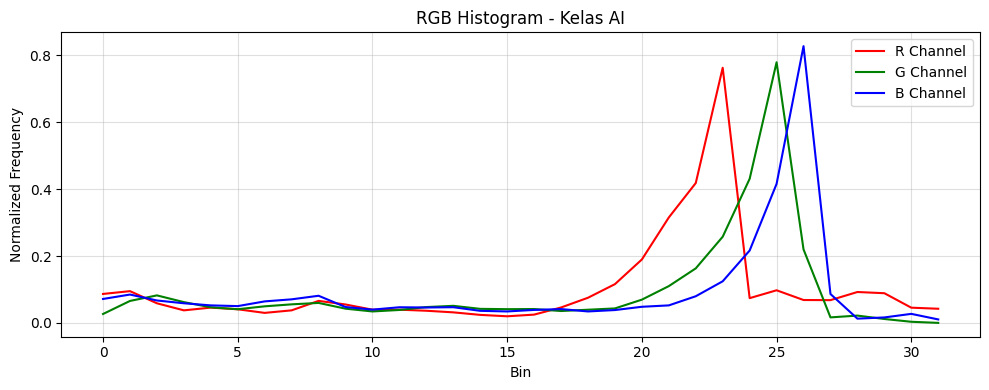

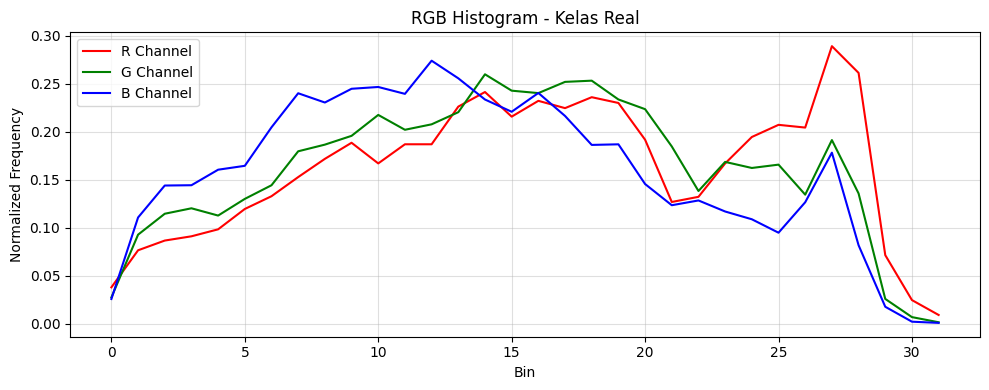


Bentuk array fitur RGB Histogram: (3200, 96)
Jumlah label: 3200

CONTOH VEKTOR FITUR HISTOGRAM RGB PER KELAS

--- Kelas: REAL ---
Panjang Vektor: 96
Vektor Fitur Numerik:
[0.03799316 0.07661953 0.08675104 0.09118357 0.09846559 0.11967844
 0.13297604 0.15292245 0.17191903 0.18869933 0.16716988 0.1871163
 0.1871163  0.22637588 0.24157314 0.21592776 0.23239146 0.22479284
 0.23619078 0.2301752  0.19186543 0.12696046 0.13234283 0.16716988
 0.19471492 0.20737931 0.20452982 0.2893812  0.26151955 0.07155377
 0.02469555 0.00918168 0.02749054 0.09289908 0.11470192 0.12038962
 0.11280602 0.1301851  0.14440435 0.17979448 0.1867461  0.19590962
 0.21771246 0.20222929 0.20791698 0.22055632 0.26005423 0.24299112
 0.24046326 0.25215465 0.25341856 0.2338276  0.22371614 0.1848502
 0.13840066 0.16873506 0.1624154  0.16589122 0.13460886 0.19148585
 0.1358728  0.02591063 0.00695163 0.00157992 0.02583554 0.11081267
 0.14411873 0.14443    0.16061611 0.16466264 0.20481668 0.24030164
 0.23065221 0.24497071 0.2

In [ ]:
# Fungsi Ekstraksi Fitur Histogram Warna RGB
def extract_rgb_histogram(images, bins=32):

    features = []

    for img in images:
        # Hitung histogram tiap channel
        hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256])
        hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256])
        hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256])

        # Normalisasi histogram
        hist_r = cv2.normalize(hist_r, hist_r).flatten()
        hist_g = cv2.normalize(hist_g, hist_g).flatten()
        hist_b = cv2.normalize(hist_b, hist_b).flatten()

        # Gabungkan jadi satu vektor
        hist_feature = np.hstack([hist_r, hist_g, hist_b])
        features.append(hist_feature)

    return np.array(features)

# Fungsi Visualisasi Histogram RGB
def show_rgb_histogram_example(image_rgb, label_name, bins=32):

    colors = ('r', 'g', 'b')
    plt.figure(figsize=(10, 4))

    for i, col in enumerate(colors):
        hist = cv2.calcHist([image_rgb], [i], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        plt.plot(hist, color=col, label=f'{col.upper()} Channel')

    plt.title(f'RGB Histogram - Kelas {label_name}')
    plt.xlabel('Bin')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()


# Mencari tahu di mana data Real dimulai
start_index_real = len(ai_rgb)

# Visualisasi contoh histogram yang benar
show_rgb_histogram_example(X_rgb[0], "AI")
show_rgb_histogram_example(X_rgb[start_index_real], "Real")

# Ekstraksi Fitur Histogram RGB
X_color = extract_rgb_histogram(X_rgb)
y_color = np.array(y)

print("\nBentuk array fitur RGB Histogram:", X_color.shape)
print("Jumlah label:", len(y_color))

# Tampilkan Contoh Vektor Fitur per Kelas
print("\n" + "="*60)
print("CONTOH VEKTOR FITUR HISTOGRAM RGB PER KELAS")
print("="*60)

class_names = ["Real", "AI"]
class_mapping = {"Real": 0, "AI": 1}

for class_name in class_names:
    label_val = class_mapping[class_name]
    idx_list = np.where(y_color == label_val)[0]

    if len(idx_list) == 0:
        print(f"\nTidak ada data untuk kelas {class_name}")
        continue

    sample_vector = X_color[idx_list[0]]

    print(f"\n--- Kelas: {class_name.upper()} ---")
    print(f"Panjang Vektor: {len(sample_vector)}")
    print("Vektor Fitur Numerik:")
    print(sample_vector)


 LBP

Ekstraksi LBP selesai
Bentuk array fitur LBP: (3200, 26)
Jumlah label: 3200


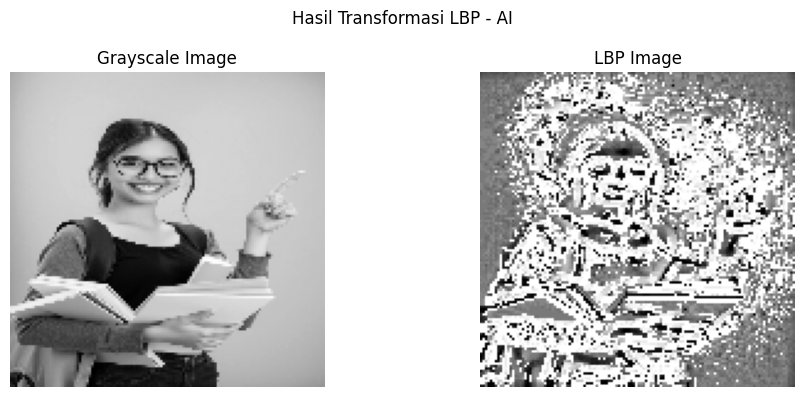

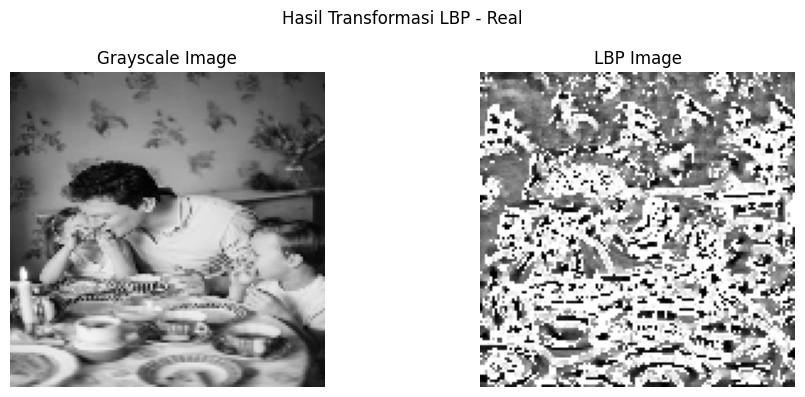


VEKTOR FITUR LBP UNTUK SETIAP KELAS

--- Kelas: REAL ---
Panjang Vektor: 26
Vektor Fitur Numerik:
[0.034729   0.02520752 0.02337646 0.01849365 0.01733398 0.0168457
 0.0199585  0.0244751  0.02801514 0.03356934 0.0435791  0.05499268
 0.05194092 0.04351807 0.02703857 0.01953125 0.01580811 0.01062012
 0.01116943 0.01104736 0.01190186 0.01245117 0.01776123 0.0222168
 0.04296875 0.3614502 ]

--- Kelas: AI ---
Panjang Vektor: 26
Vektor Fitur Numerik:
[0.02740479 0.0199585  0.01208496 0.01043701 0.00982666 0.01092529
 0.00866699 0.01177979 0.01568604 0.02557373 0.03918457 0.07012939
 0.08740234 0.06567383 0.0390625  0.02728271 0.01721191 0.01300049
 0.00866699 0.00958252 0.00933838 0.01068115 0.01654053 0.02319336
 0.03826904 0.37243652]


In [ ]:
# LBP: Ekstraksi, Visualisasi, dan Tampilkan Vektor

# 1. Fungsi Ekstraksi LBP
def extract_lbp(images):
    """
    Ekstraksi fitur LBP dari list citra RGB
    """
    radius = 3
    n_points = 8 * radius
    method = 'uniform'
    features = []

    for img in images:
        # Konversi ke grayscale untuk LBP
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Ekstraksi pola LBP
        lbp = local_binary_pattern(gray, n_points, radius, method)

        # Hitung histogram pola (Vektor Fitur)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float") / (hist.sum() + 1e-6)  # Normalisasi

        features.append(hist)

    return np.array(features)

# 2. Fungsi Visualisasi LBP
def show_lbp_example(image_rgb, label_name):
    """
    Menampilkan LBP untuk satu gambar
    """
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp_image = local_binary_pattern(gray, n_points, radius, method='uniform')

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(gray, cmap='gray')
    axs[0].set_title("Grayscale Image")
    axs[1].imshow(lbp_image, cmap='gray')
    axs[1].set_title("LBP Image")

    for ax in axs:
        ax.axis('off')

    plt.suptitle(f"Hasil Transformasi LBP - {label_name}")
    plt.tight_layout()
    plt.show()


# 3. Ekstraksi LBP untuk semua gambar

# Menggunakan ai_rgb dan real_rgb dari hasil preprocessing
X_lbp_ai = extract_lbp(ai_rgb)
X_lbp_real = extract_lbp(real_rgb)

# Gabungkan fitur dan label
X_lbp = np.vstack((X_lbp_ai, X_lbp_real))
y_lbp = np.array([1] * len(X_lbp_ai) + [0] * len(X_lbp_real))

print("Ekstraksi LBP selesai")
print(f"Bentuk array fitur LBP: {X_lbp.shape}")
print(f"Jumlah label: {len(y_lbp)}")

# Sampel AI (index 0 karena ai_rgb diproses duluan)
show_lbp_example(ai_rgb[0], "AI")

# Sampel Real (index 0 dari real_rgb)
show_lbp_example(real_rgb[0], "Real")

# 4. Tampilkan vektor LBP contoh untuk tiap kelas
print("\n" + "="*50)
print("VEKTOR FITUR LBP UNTUK SETIAP KELAS")
print("="*50)

class_names = ["Real", "AI"]
class_mapping = {"Real": 0, "AI": 1}

for class_name in class_names:
    label_val = class_mapping[class_name]
    idx_list = np.where(y_lbp == label_val)[0]

    if len(idx_list) == 0:
        continue

    vector_to_show = X_lbp[idx_list[0]]
    print(f"\n--- Kelas: {class_name.upper()} ---")
    print(f"Panjang Vektor: {len(vector_to_show)}")
    print("Vektor Fitur Numerik:")
    print(vector_to_show)

###Kombinasi Fitur

In [ ]:
print("Mempersiapkan semua kombinasi fitur...")

# Skenario 1-3: Fitur Tunggal
X_sc_color = X_color
X_sc_hog   = X_hog
X_sc_lbp   = X_lbp

# Skenario 4-7: Kombinasi Fitur (Feature Fusion)
X_color_hog = np.hstack((X_color, X_hog))
X_color_lbp = np.hstack((X_color, X_lbp))
X_hog_lbp   = np.hstack((X_hog, X_lbp))
X_all       = np.hstack((X_color, X_hog, X_lbp))

feature_sets = {
    "Histogram Warna": X_sc_color,
    "HOG": X_sc_hog,
    "LBP": X_sc_lbp,
    "Warna + HOG": X_color_hog,
    "Warna + LBP": X_color_lbp,
    "HOG + LBP": X_hog_lbp,
    "Warna + HOG + LBP": X_all
}

print("Persiapan selesai.")

# Menampilkan Jumlah Fitur per Skenario
print("\n" + "="*60)
print("       RINCIAN JUMLAH FITUR TOTAL PER SKENARIO")
print("="*60)
for name, X_data in feature_sets.items():
    print(f"- Skenario '{name:<20}': {X_data.shape[1]} fitur total")

Mempersiapkan semua kombinasi fitur...
Persiapan selesai.

       RINCIAN JUMLAH FITUR TOTAL PER SKENARIO
- Skenario 'Histogram Warna     ': 96 fitur total
- Skenario 'HOG                 ': 8100 fitur total
- Skenario 'LBP                 ': 26 fitur total
- Skenario 'Warna + HOG         ': 8196 fitur total
- Skenario 'Warna + LBP         ': 122 fitur total
- Skenario 'HOG + LBP           ': 8126 fitur total
- Skenario 'Warna + HOG + LBP   ': 8222 fitur total


###Training dan Evaluasi


       MEMULAI EVALUASI UNTUK FITUR: HISTOGRAM WARNA

Hasil Akhir Skenario 'Histogram Warna':
Akurasi: 90.62%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Real       0.94      0.87      0.90       320
          AI       0.88      0.94      0.91       320

    accuracy                           0.91       640
   macro avg       0.91      0.91      0.91       640
weighted avg       0.91      0.91      0.91       640



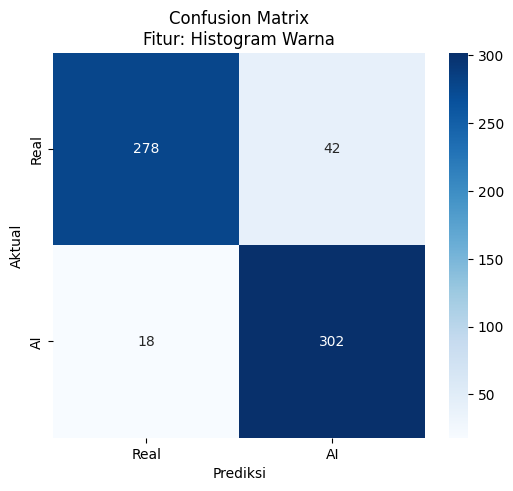


       MEMULAI EVALUASI UNTUK FITUR: HOG

Hasil Akhir Skenario 'HOG':
Akurasi: 73.75%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Real       0.77      0.68      0.72       320
          AI       0.71      0.79      0.75       320

    accuracy                           0.74       640
   macro avg       0.74      0.74      0.74       640
weighted avg       0.74      0.74      0.74       640



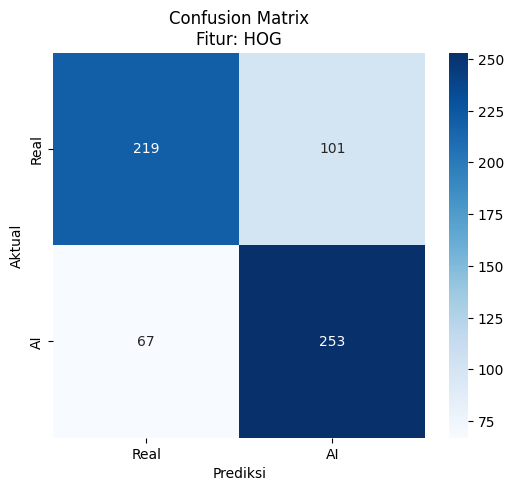


       MEMULAI EVALUASI UNTUK FITUR: LBP

Hasil Akhir Skenario 'LBP':
Akurasi: 78.44%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Real       0.82      0.73      0.77       320
          AI       0.76      0.84      0.80       320

    accuracy                           0.78       640
   macro avg       0.79      0.78      0.78       640
weighted avg       0.79      0.78      0.78       640



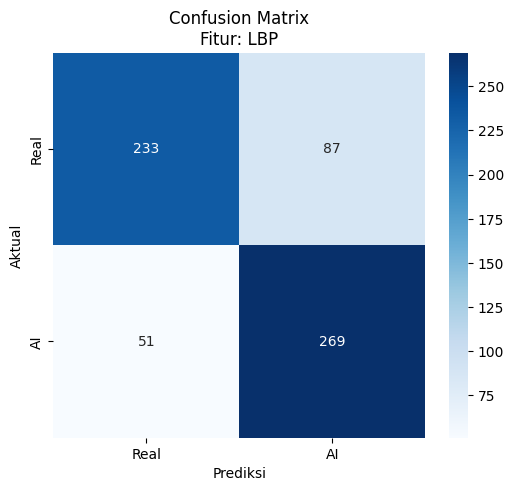


       MEMULAI EVALUASI UNTUK FITUR: WARNA + HOG

Hasil Akhir Skenario 'Warna + HOG':
Akurasi: 84.06%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Real       0.88      0.79      0.83       320
          AI       0.81      0.89      0.85       320

    accuracy                           0.84       640
   macro avg       0.84      0.84      0.84       640
weighted avg       0.84      0.84      0.84       640



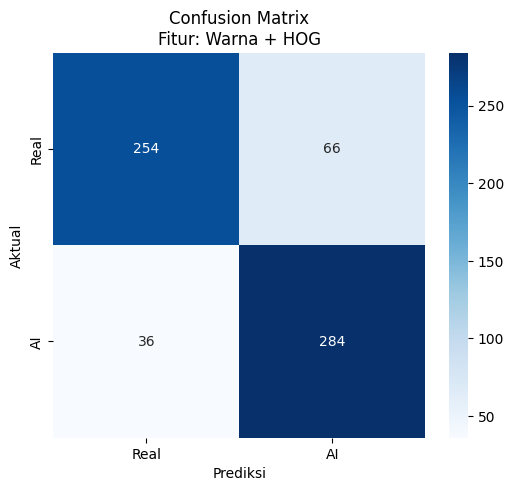


       MEMULAI EVALUASI UNTUK FITUR: WARNA + LBP

Hasil Akhir Skenario 'Warna + LBP':
Akurasi: 92.66%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Real       0.94      0.91      0.93       320
          AI       0.91      0.94      0.93       320

    accuracy                           0.93       640
   macro avg       0.93      0.93      0.93       640
weighted avg       0.93      0.93      0.93       640



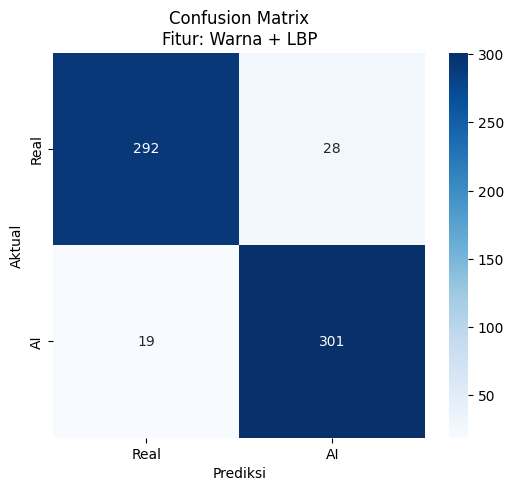


       MEMULAI EVALUASI UNTUK FITUR: HOG + LBP

Hasil Akhir Skenario 'HOG + LBP':
Akurasi: 77.50%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Real       0.81      0.72      0.76       320
          AI       0.75      0.83      0.79       320

    accuracy                           0.78       640
   macro avg       0.78      0.78      0.77       640
weighted avg       0.78      0.78      0.77       640



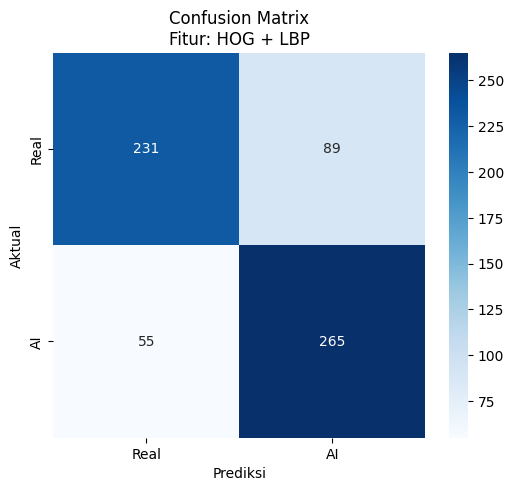


       MEMULAI EVALUASI UNTUK FITUR: WARNA + HOG + LBP

Hasil Akhir Skenario 'Warna + HOG + LBP':
Akurasi: 86.09%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Real       0.89      0.82      0.86       320
          AI       0.83      0.90      0.87       320

    accuracy                           0.86       640
   macro avg       0.86      0.86      0.86       640
weighted avg       0.86      0.86      0.86       640



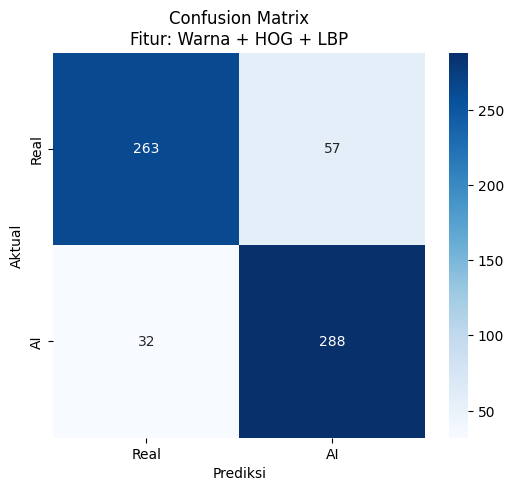

In [ ]:
results = {}

# Looping melalui setiap skenario fitur
for name, X in feature_sets.items():
    print("\n" + "="*60)
    print(f"       MEMULAI EVALUASI UNTUK FITUR: {name.upper()}")
    print("="*60)

    # 1. Bagi data menjadi Training dan Testing (80:20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2. Membuat Pipeline: Standarisasi Data + Model SVM
    # Scaling karena rentang nilai HOG, RGB, dan LBP sangat berbeda
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
    ])

    # 3. Training Model
    pipeline.fit(X_train, y_train)

    # 4. Prediksi
    y_pred = pipeline.predict(X_test)

    # 5. Hitung Akurasi
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # 6. Tampilkan Hasil
    print(f"\nHasil Akhir Skenario '{name}':")
    print(f"Akurasi: {accuracy * 100:.2f}%")

    print("\nLaporan Klasifikasi:")
    # target_names disesuaikan dengan label kita (0=Real, 1=AI)
    print(classification_report(y_test, y_pred, target_names=["Real", "AI"]))

    # 7. Visualisasi Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Real", "AI"],
                yticklabels=["Real", "AI"])
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix\nFitur: {name}')
    plt.show()


       RINGKASAN PERBANDINGAN AKURASI AKHIR
Fitur: HOG                  | Akurasi: 73.75%
Fitur: HOG + LBP            | Akurasi: 77.50%
Fitur: LBP                  | Akurasi: 78.44%
Fitur: Warna + HOG          | Akurasi: 84.06%
Fitur: Warna + HOG + LBP    | Akurasi: 86.09%
Fitur: Histogram Warna      | Akurasi: 90.62%
Fitur: Warna + LBP          | Akurasi: 92.66%


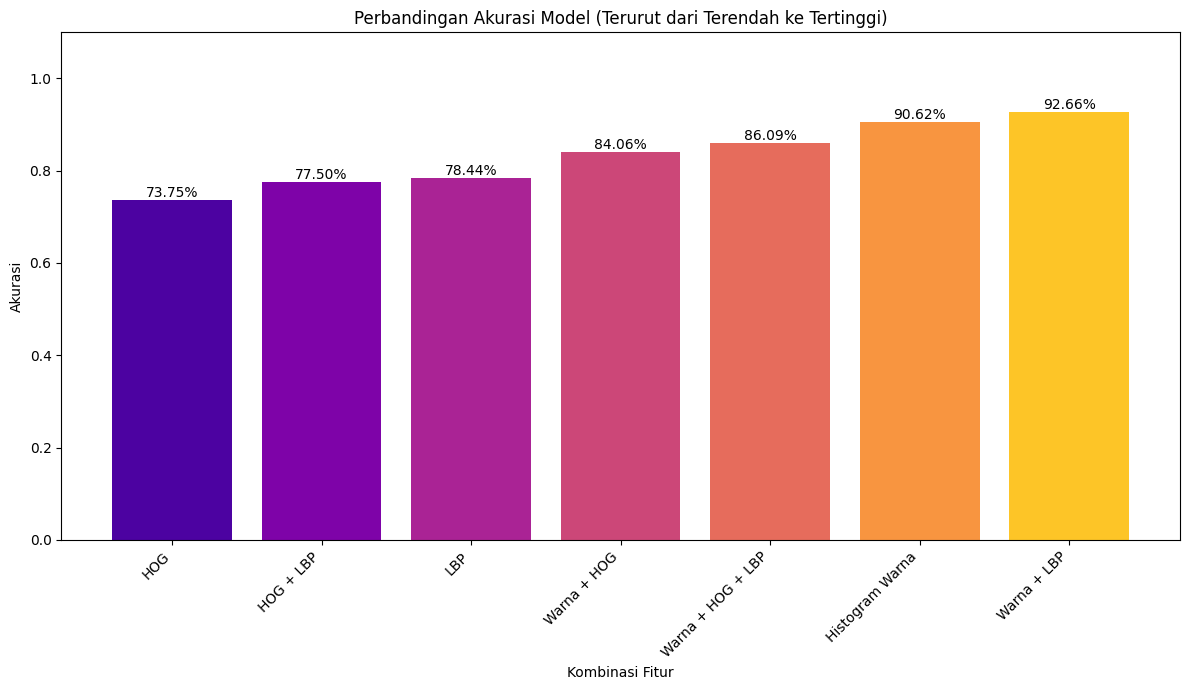

In [ ]:
# RINGKASAN HASIL AKHIR

# ---  Mengurutkan hasil dari terkecil ke terbesar ---
sorted_results_asc = sorted(results.items(), key=lambda item: item[1])

print("\n" + "="*60)
print("       RINGKASAN PERBANDINGAN AKURASI AKHIR")
print("="*60)

for name, acc in sorted_results_asc:
    print(f"Fitur: {name:<20} | Akurasi: {acc * 100:.2f}%")

# --- Menyiapkan data untuk grafik yang terurut ---
sorted_names = [item[0] for item in sorted_results_asc]
sorted_accuracies = [item[1] for item in sorted_results_asc]

# Membuat plot batang untuk perbandingan visual
plt.figure(figsize=(12, 7))
barplot = plt.bar(sorted_names, sorted_accuracies, color=sns.color_palette("plasma", len(sorted_names)))

for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval * 100:.2f}%', va='bottom', ha='center')

plt.xlabel("Kombinasi Fitur")
plt.ylabel("Akurasi")
plt.title("Perbandingan Akurasi Model (Terurut dari Terendah ke Tertinggi)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

In [ ]:
# Training model terbaik: Warna + LBP
X_best = np.hstack((X_color, X_lbp))

best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

best_pipeline.fit(X_best, y)
print("Model terbaik (Warna + LBP) siap digunakan!")

# Simpan model
with open("svm_ai_vs_real_model.sav", "wb") as file:
    pickle.dump(best_pipeline, file)

print("Model berhasil disimpan!")

Model terbaik (Warna + LBP) siap digunakan!
Model berhasil disimpan!


Prediksi Gambar Baru

In [ ]:
def predict_single_image(image_path, model_pipeline):
    """
    Memprediksi satu gambar menggunakan skenario terbaik (Warna + LBP)
    """
    # 1. Load Gambar
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Gambar tidak ditemukan di {image_path}")
        return None, None, None

    # Konversi ke RGB untuk konsistensi dengan training
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Preprocessing (Resize ke 128x128)
    resized_rgb = cv2.resize(img_rgb, (128, 128))

    # 3. Ekstraksi Fitur (Hanya yang dipakai di skenario terbaik)
    color_feat = extract_rgb_histogram([resized_rgb])[0]
    lbp_feat = extract_lbp([resized_rgb])[0]

    # 4. Gabungkan Fitur (Fusion)
    combined_features = np.hstack((color_feat, lbp_feat))

    # 5. Reshape (1, -1) karena hanya 1 data
    final_features = combined_features.reshape(1, -1)

    # 6. Prediksi menggunakan Pipeline
    prediction_code = model_pipeline.predict(final_features)

    # Mapping label
    label_map = {0: "Real", 1: "AI"}
    prediction_name = label_map[prediction_code[0]]

    # 7. Confidence Score
    proba = model_pipeline.predict_proba(final_features)
    confidence = np.max(proba) * 100

    return img_rgb, prediction_name, confidence

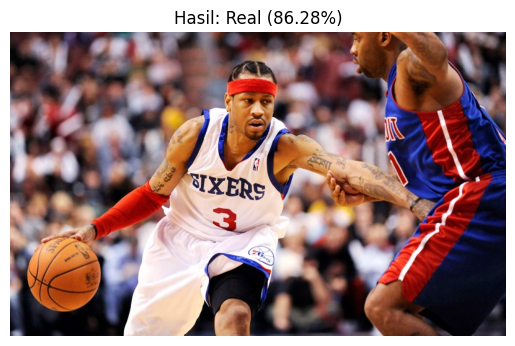

In [ ]:
# Mencoba Gambar Baru
path_tes = "gambar_baru2.jpg"
original, hasil, skor = predict_single_image(path_tes, best_pipeline)

if original is not None:
    plt.imshow(original)
    plt.title(f"Hasil: {hasil} ({skor:.2f}%)")
    plt.axis('off')
    plt.show()